# things to run in terminal to import necessary libraries. 

### make the appropriate changes in the Dockerfile to include them upon initialisation 

In [1]:
#pip install protobuf==3.20.3

## data pipeline

#### (tf.data gia parallelization sta preassigned weights)

In [ ]:
import tensorflow as tf
import h5py
import numpy as np
import glob

# Constants
BATCH_SIZE = 16 # Adjust based on your GPU VRAM
PAD_VAL = 0.0   # Padding value for neural features
PHONEME_PAD = -1 # Special value for padding labels

def get_dataset(data_dir, split='train'):
    # Get list of files
    files = glob.glob(f"{data_dir}/*{split}*.hdf5")
    
    def generator():
        for file_path in files:
            with h5py.File(file_path, 'r') as f:
                keys = list(f.keys())
                for key in keys:
                    group = f[key]
                    # Neural features: (Time, 512)
                    # We transpose to (512, Time) if using 1D Conv over time
                    features = group['input_features'][:] 
                    
                    if split == 'test':
                        yield features, key # Return ID for submission
                    else:
                        # Labels: integer phoneme sequence
                        labels = group['seq_class_ids'][:]
                        yield features, labels

    # Define output signature
    if split == 'test':
        output_signature = (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    else:
        output_signature = (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )

    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    
    # Physics/Optimization Note: Padding creates a uniform tensor structure, 
    # essential for efficient batch matrix multiplication on the GPU.
    ds = ds.padded_batch(BATCH_SIZE, padded_shapes=([None, 512], [None]), padding_values=(PAD_VAL, PHONEME_PAD))
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

2025-12-13 12:51:12.313867: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-13 12:51:12.328467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-13 12:51:12.333296: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-13 12:51:12.346062: I tensorflow/core/platform/cpu_feature_guard.cc:211] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

# 2. Dynamic system 
#### (1D Conv & RNN Finite Impulse Response-> Hamitonianh tou generation process )

#### Model Build

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

class BrainToTextModel(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        # 1. Learnable Filtering (Signal Processing)
        # Downsample time dimension to make optimization easier (shorter dependencies)
        self.conv1 = layers.Conv1D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')
        self.norm1 = layers.LayerNormalization() # Crucial for convergence speed
        
        # 2. Dynamical System Modeling (RNN)
        # Bi-directional because 'future' brain states help resolve 'past' ambiguities
        self.rnn1 = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3))
        self.rnn2 = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3))
        
        # 3. Projection to Phoneme Probability Space
        self.dense = layers.Dense(num_classes + 1) # +1 for CTC Blank symbol

    def call(self, inputs, training=False):
        # inputs shape: (Batch, Time, Features)
        x = self.conv1(inputs)
        x = self.norm1(x)
        
        x = self.rnn1(x, training=training)
        x = self.rnn2(x, training=training)
        
        # Output shape: (Batch, Time/2, NumClasses+1)
        return self.dense(x)

# Note: num_classes corresponds to the phone me vocabulary size provided in the data description
model = BrainToTextModel(num_classes=40) # Example size, check data!

I0000 00:00:1765630274.476687     703 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765630274.538700     703 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765630274.540522     703 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1765630274.542855     703 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

# 3. Optimisation 
#### Connectionist Temporal Classification -> analogo ths arxhs elaxisths drashs Louis de Mapertuis 
#### AdamW -> adam me weight decay: O adam ektima thn 1h kai 2h moment tou decay (m.o kai variance) kai analogos kanei adapt to LR xehorista to weight decay dra san L2 reg 
+ gradient inspection gia ka8e instance 

In [4]:
@tf.function
def ctc_loss(y_true, y_pred, input_lengths, label_lengths):
    return tf.nn.ctc_loss(
        labels=y_true,
        logits=y_pred,
        label_length=label_lengths,
        logit_length=input_lengths,
        logits_time_major=False,
        blank_index=-1 # inferred as last index usually, check TF docs specific version
    )

optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5)

def train_step(batch_features, batch_labels):
    # Create masks for variable lengths
    # Features are padded with 0.0, labels with -1
    
    # Calculate actual lengths for CTC
    input_lengths = tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(batch_features, 0.0), axis=2), tf.int32), axis=1)
    # Since we use Conv1D with stride 2, the time dimension is halved
    input_lengths = input_lengths // 2 
    
    label_lengths = tf.reduce_sum(tf.cast(tf.not_equal(batch_labels, -1), tf.int32), axis=1)

    with tf.GradientTape() as tape:
        logits = model(batch_features, training=True)
        
        # Sparse CTC requires specific formatting, here using dense version for simplicity
        # (You might need tf.sparse.from_dense if using sparse_ctc_loss)
        loss_value = tf.reduce_mean(tf.nn.ctc_loss(
            labels=batch_labels,
            logits=logits,
            label_length=label_lengths,
            logit_length=input_lengths,
            logits_time_major=False,
            blank_index=model.dense.units - 1
        ))

    grads = tape.gradient(loss_value, model.trainable_variables)
    
    # Gradient Clipping: "Optimization Safety Rail"
    # Prevents "exploding gradients" common in RNNs (dynamical instability)
    grads, _ = tf.clip_by_global_norm(grads, 5.0)
    
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

# 4 analysi sygklishs: 

#### gia visualisation tou optimisation kata th diarkeia tou training. Simulated annealing opws kai sto ISING model 

In [5]:
# Scheduler Example
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000
)
optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=1e-5)

''+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target+ptx85 (ignoring feature)
'' is not a recognized feature for this target+ptx85 (ignoring feature)
' is not a recognized feature for this target' (ignoring feature)
+ptx85'' is not a recognized feature for this target+ptx85 (ignoring feature)
' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring f

# 5 inference / Decoding 

+ greedy decodiing: epilegw th megisth pi8anothta gia ka8e vhma (oxi kai toso kalo tlk)
+ Beam search: Kratame ta kalytera K pio pi8ana paths gia nv to oliko megisto ths seiriakhs pi8anothtas

In [6]:
def decode_batch(logits, input_lengths):
    # logits: (Batch, Time, Vocab)
    # Permute to (Time, Batch, Vocab) for TF CTC decode
    logits_t = tf.transpose(logits, [1, 0, 2])
    
    decoded, log_probs = tf.nn.ctc_beam_search_decoder(
        logits_t,
        input_lengths,
        beam_width=10, # Optimization parameter: trade-off between speed and accuracy
        top_paths=1
    )
    
    # Convert sparse tensor to dense sequences of phoneme IDs
    return tf.sparse.to_dense(decoded[0])

# 6. Execution

## Imports and TF initialisation

In [7]:
import tensorflow as tf
import h5py
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import time

# --- GPU CONFIGURATION (MUST BE FIRST) ---
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Running on GPU: {gpus[0].name}")
    except RuntimeError as e:
        # This error is expected if you re-run the cell without restarting kernel
        print("GPU already initialized (Memory growth could not be set, but that's okay if it was set previously).")
else:
    print("WARNING: Running on CPU. Training will be slow.")

# --- HYPERPARAMETERS ---
BATCH_SIZE = 16          # Trade-off between stochasticity and stability
LEARNING_RATE = 1e-4     # Step size in the parameter space
EPOCHS = 10              # Number of full passes through the data
DATA_DIR = "./"          # Assuming data is in the same folder as the notebook

print(f"TensorFlow Version: {tf.__version__}") 

GPU already initialized (Memory growth could not be set, but that's okay if it was set previously).
TensorFlow Version: 2.17.0


## phonetic dictionary 

In [8]:
# 2. Phoneme Mapping
# This list matches the integer IDs in 'seq_class_ids'
LOGIT_TO_PHONEME = [
    'BLANK', 'AA', 'AE', 'AH', 'AO', 'AW', 'AY', 'B', 'CH', 'D', 'DH', 
    'EH', 'ER', 'EY', 'F', 'G', 'HH', 'IH', 'IY', 'JH', 'K', 'L', 'M', 
    'N', 'NG', 'OW', 'OY', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UW', 
    'V', 'W', 'Y', 'Z', 'ZH', ' | '
]

NUM_CLASSES = len(LOGIT_TO_PHONEME) 
print(f"Vocabulary Size (System States): {NUM_CLASSES}")

Vocabulary Size (System States): 41


## Data pipeline  with the corresponding train/test/val split 

In [9]:
def get_dataset(data_dir, split='train', batch_size=16):
    # 1. Search for files recursively in all date folders
    # Pattern: /data_dir/**/ *train*.hdf5
    search_pattern = os.path.join(data_dir, "**", f"*{split}*.hdf5")
    files = glob.glob(search_pattern, recursive=True)
    
    if not files:
        raise ValueError(f"CRITICAL ERROR: No files found for split '{split}' in {data_dir}")
    
    print(f"[{split.upper()}] Found {len(files)} files. (e.g., {os.path.basename(files[0])})")

    def generator():
        for file_path in files:
            try:
                with h5py.File(file_path, 'r') as f:
                    keys = list(f.keys())
                    for key in keys:
                        group = f[key]
                        
                        # Features: (Time, 512)
                        features = group['input_features'][:] 
                        
                        if split == 'test':
                            yield features, key 
                        else:
                            # Labels: (Seq_Len,)
                            if 'seq_class_ids' in group:
                                labels = group['seq_class_ids'][:].astype(np.int32)
                                yield features, labels
            except Exception as e:
                print(f"Skipping corrupt file {file_path}: {e}")

    # 2. Define Tensor Types
    if split == 'test':
        output_signature = (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.string)
        )
    else:
        output_signature = (
            tf.TensorSpec(shape=(None, 512), dtype=tf.float32),
            tf.TensorSpec(shape=(None,), dtype=tf.int32)
        )

    # 3. Create & Optimize Dataset
    ds = tf.data.Dataset.from_generator(generator, output_signature=output_signature)
    
    # Padding: Features get 0.0, Labels get -1 (to mark end of sequence)
    padded_shapes = ([None, 512], [None]) if split != 'test' else ([None, 512], [])
    padding_values = (0.0, -1) if split != 'test' else (0.0, "")
    
    ds = ds.padded_batch(batch_size, padded_shapes=padded_shapes, padding_values=padding_values)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

# --- INITIALIZE PIPELINES ---
print("Building Data Pipelines...")

# 1. Training Data (The "fitting" set)
train_ds = get_dataset(DATA_DIR, split='train', batch_size=BATCH_SIZE)

# 2. Validation Data (The "theory check" set)
# Note: 'val' is the standard keyword often used in filenames, checking your structure
val_ds = get_dataset(DATA_DIR, split='val', batch_size=BATCH_SIZE)

print("Pipelines Ready.")

Building Data Pipelines...
[TRAIN] Found 46 files. (e.g., data_train.hdf5)
[VAL] Found 41 files. (e.g., data_val.hdf5)
Pipelines Ready.


## Model initialisation 

In [10]:
from tensorflow.keras import layers

class BrainToTextModel(tf.keras.Model):
    def __init__(self, num_classes):
        super().__init__()
        # 1. Signal Processing: 1D Conv acts as a temporal filter
        self.conv1 = layers.Conv1D(filters=256, kernel_size=3, strides=2, padding='same', activation='relu')
        self.norm1 = layers.LayerNormalization() 
        
        # 2. System Dynamics: 
        # FIX APPLIED: reset_after=False
        # This disables the specific CuDNN implementation that is crashing with v9.0,
        # forcing TF to use a generic, robust GPU implementation instead.
        self.rnn1 = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3, reset_after=False))
        self.rnn2 = layers.Bidirectional(layers.GRU(256, return_sequences=True, dropout=0.3, reset_after=False))
        
        # 3. Readout
        self.dense = layers.Dense(num_classes + 1) 

    def call(self, inputs, training=False):
        x = self.conv1(inputs)
        x = self.norm1(x)
        x = self.rnn1(x, training=training)
        x = self.rnn2(x, training=training)
        return self.dense(x)

# Instantiate
model = BrainToTextModel(num_classes=NUM_CLASSES)
# Dummy call to initialize weights (build the graph)
dummy_input = tf.zeros((1, 512, 512)) # (Batch, Time, Feat)
_ = model(dummy_input)
print("Model built successfully with robust GRU layers.")

2025-12-13 12:51:15.588739: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90701
W0000 00:00:1765630275.640366     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.645405     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.646181     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.646889     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.647038     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.652960     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.653607     703 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630275.653729     703 gpu_

Model built successfully with robust GRU layers.


## Optimisation loop with Validation loss with generalised Boundary conditions 

In [11]:
# Optimizer
optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE, weight_decay=1e-5)

# Metrics tracking
train_loss_history = []
val_loss_history = []

# --- THE FIX: INPUT SIGNATURES ---
# We explicitly tell TF that the dimensions are (Batch=Any, Time=Any, Features=512)
# This prevents it from rebuilding the graph when the time length changes.

@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None, 512), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32)
])
def train_step(batch_features, batch_labels):
    # Calculate lengths
    # Input length is halved due to Conv1D stride=2
    input_lengths = tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(batch_features, 0.0), axis=2), tf.int32), axis=1) // 2
    label_lengths = tf.reduce_sum(tf.cast(tf.not_equal(batch_labels, -1), tf.int32), axis=1)

    with tf.GradientTape() as tape:
        logits = model(batch_features, training=True)
        
        loss_value = tf.nn.ctc_loss(
            labels=batch_labels, 
            logits=logits, 
            label_length=label_lengths, 
            logit_length=input_lengths, 
            logits_time_major=False, 
            blank_index=NUM_CLASSES
        )
        loss_value = tf.reduce_mean(loss_value)

    grads = tape.gradient(loss_value, model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, 5.0) 
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

@tf.function(input_signature=[
    tf.TensorSpec(shape=(None, None, 512), dtype=tf.float32),
    tf.TensorSpec(shape=(None, None), dtype=tf.int32)
])
def val_step(batch_features, batch_labels):
    input_lengths = tf.reduce_sum(tf.cast(tf.reduce_any(tf.not_equal(batch_features, 0.0), axis=2), tf.int32), axis=1) // 2
    label_lengths = tf.reduce_sum(tf.cast(tf.not_equal(batch_labels, -1), tf.int32), axis=1)
    
    logits = model(batch_features, training=False)
    loss_value = tf.nn.ctc_loss(
        labels=batch_labels, 
        logits=logits, 
        label_length=label_lengths, 
        logit_length=input_lengths, 
        logits_time_major=False, 
        blank_index=NUM_CLASSES
    )
    return tf.reduce_mean(loss_value)

# --- EXECUTION LOOP ---
print(f"Starting Generalized Optimization for {EPOCHS} Epochs...")
start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # 1. Training Phase
    train_loss_avg = tf.keras.metrics.Mean()
    for step, (features, labels) in enumerate(train_ds):
        try:
            loss = train_step(features, labels)
            train_loss_avg.update_state(loss)
            
            if step % 100 == 0:
                print(f"  Batch {step}: Train Loss = {loss:.4f}")
        except tf.errors.InvalidArgumentError as e:
            print(f"Skipping bad batch at step {step}: {e}")
            continue
            
    # 2. Validation Phase
    val_loss_avg = tf.keras.metrics.Mean()
    for features, labels in val_ds:
        v_loss = val_step(features, labels)
        val_loss_avg.update_state(v_loss)
    
    # 3. Logging
    t_loss = train_loss_avg.result()
    v_loss = val_loss_avg.result()
    train_loss_history.append(t_loss)
    val_loss_history.append(v_loss)
    
    print(f"  >> RESULTS: Train Loss: {t_loss:.4f} | Val Loss: {v_loss:.4f}")

print(f"\nOptimization Complete. Total time: {(time.time() - start_time)/60:.2f} min.")

Starting Generalized Optimization for 10 Epochs...

Epoch 1/10


W0000 00:00:1765630282.613878     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.615021     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.616023     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.617213     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.618206     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.619349     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.635289     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.636838     768 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630282.638061     768 gp

  Batch 0: Train Loss = 2116.5608


W0000 00:00:1765630298.777824     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.778676     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.779546     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.780410     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.781407     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.782401     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.783499     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.784422     757 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630298.785307     757 gp

  Batch 100: Train Loss = 1275.0885


W0000 00:00:1765630884.412875     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.413611     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.414360     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.415311     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.416285     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.417288     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.418379     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.419392     762 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765630884.420203     762 gp

  Batch 200: Train Loss = 1256.4746


W0000 00:00:1765631463.355691     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.357293     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.357950     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.358655     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.359327     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.360041     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.360754     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.361594     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765631463.362457     767 gp

  Batch 300: Train Loss = 1351.8379


W0000 00:00:1765632082.244125     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.245436     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.246069     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.246719     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.247317     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.247980     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.248700     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.249452     764 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632082.250221     764 gp

  Batch 400: Train Loss = 1299.3706


W0000 00:00:1765632545.405025     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.405971     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.406940     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.407899     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.408845     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.409943     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.411178     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.412205     759 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765632545.413194     759 gp

  Batch 500: Train Loss = 1400.9584


W0000 00:00:1765633181.490593     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.492239     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.493137     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.494077     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.494972     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.495906     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.496850     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.497947     765 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633181.499085     765 gp

  >> RESULTS: Train Loss: 1305.8608 | Val Loss: 1384.8698

Epoch 2/10


W0000 00:00:1765633695.905842     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.906851     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.907879     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.908901     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.909916     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.911239     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.912645     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.913752     758 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633695.914802     758 gp

  Batch 0: Train Loss = 1310.3868


W0000 00:00:1765633718.418160     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.419638     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.420290     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.420955     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.421572     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.422238     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.422935     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.423699     767 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1765633718.424477     767 gp

  Batch 100: Train Loss = 1313.8118
  Batch 200: Train Loss = 1274.2682
  Batch 300: Train Loss = 1363.4248
  Batch 400: Train Loss = 1308.8604
  Batch 500: Train Loss = 1406.8992


2025-12-13 14:47:32.048867: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  >> RESULTS: Train Loss: 1312.2241 | Val Loss: 1392.1910

Epoch 3/10
  Batch 0: Train Loss = 1324.9983
  Batch 100: Train Loss = 1323.4250
  Batch 200: Train Loss = 1278.5342
  Batch 300: Train Loss = 1363.6431
  Batch 400: Train Loss = 1310.3513
  Batch 500: Train Loss = 1409.2330
  >> RESULTS: Train Loss: 1316.5312 | Val Loss: 1395.6089

Epoch 4/10
  Batch 0: Train Loss = 1331.4800
  Batch 100: Train Loss = 1325.7411
  Batch 200: Train Loss = 1275.0112
  Batch 300: Train Loss = 1357.0667
  Batch 400: Train Loss = 1298.3374
  Batch 500: Train Loss = 1393.0442


2025-12-13 16:45:34.104459: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  >> RESULTS: Train Loss: 1311.4850 | Val Loss: 1379.4038

Epoch 5/10
  Batch 0: Train Loss = 1325.1958
  Batch 100: Train Loss = 1318.1526
  Batch 200: Train Loss = 1263.7178
  Batch 300: Train Loss = 1341.5596
  Batch 400: Train Loss = 1287.6431
  Batch 500: Train Loss = 1378.4186
  >> RESULTS: Train Loss: 1299.4053 | Val Loss: 1361.4834

Epoch 6/10
  Batch 0: Train Loss = 1313.1245
  Batch 100: Train Loss = 1303.3152
  Batch 200: Train Loss = 1244.4132
  Batch 300: Train Loss = 1315.3740
  Batch 400: Train Loss = 1256.3217
  Batch 500: Train Loss = 1338.1753
  >> RESULTS: Train Loss: 1276.1302 | Val Loss: 1314.3605

Epoch 7/10
  Batch 0: Train Loss = 1278.4475
  Batch 100: Train Loss = 1268.8519
  Batch 200: Train Loss = 1200.5724
  Batch 300: Train Loss = 1247.7925
  Batch 400: Train Loss = 1190.2554
  Batch 500: Train Loss = 1266.0562
  >> RESULTS: Train Loss: 1224.0068 | Val Loss: 1248.5494

Epoch 8/10
  Batch 0: Train Loss = 1246.5850
  Batch 100: Train Loss = 1229.6729
  Batch 

2025-12-13 20:37:07.417427: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


  >> RESULTS: Train Loss: 1191.9635 | Val Loss: 1243.2198

Epoch 9/10
  Batch 0: Train Loss = 1249.0610
  Batch 100: Train Loss = 1233.1321
  Batch 200: Train Loss = 1158.5396
  Batch 300: Train Loss = 1207.8752
  Batch 400: Train Loss = 1177.7944
  Batch 500: Train Loss = 1258.6355
  >> RESULTS: Train Loss: 1191.2852 | Val Loss: 1246.8358

Epoch 10/10
  Batch 0: Train Loss = 1258.8091
  Batch 100: Train Loss = 1240.4330
  Batch 200: Train Loss = 1165.5214
  Batch 300: Train Loss = 1223.1257
  Batch 400: Train Loss = 1183.4214
  Batch 500: Train Loss = 1269.8442
  >> RESULTS: Train Loss: 1198.4286 | Val Loss: 1256.7379

Optimization Complete. Total time: 576.65 min.


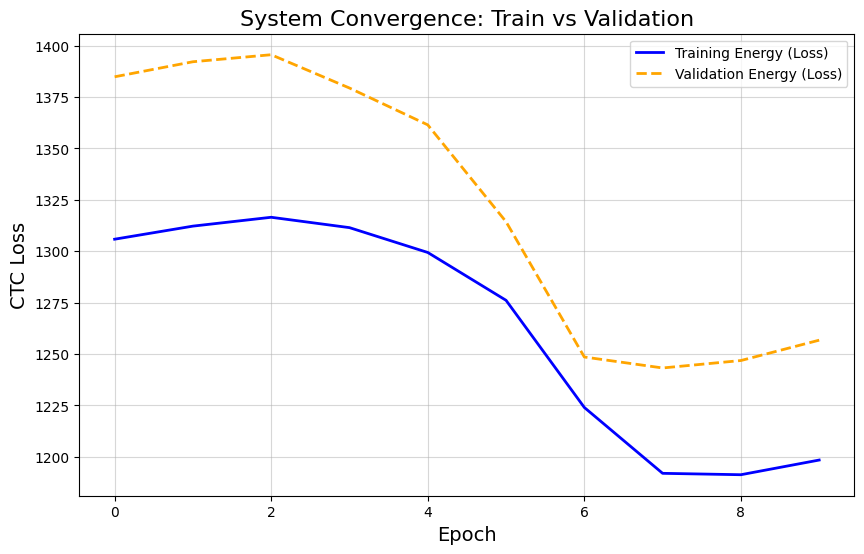

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Energy (Loss)', color='blue', linewidth=2)
plt.plot(val_loss_history, label='Validation Energy (Loss)', color='orange', linewidth=2, linestyle='--')
plt.title('System Convergence: Train vs Validation', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('CTC Loss', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.5)
plt.show()